# Imperfect tests and respondent-driven sampling

For now, we consider the network dependence induced by the RDS with no
associated model. Therefore, we treat it as a random effect for
each individual. Conditionally autoregressive (CAR) models in the
Gaussian case are used. Let $[\tilde{Q}]_{ij} = \tilde{q}_{ij}$ be a fixed matrix which measures the distance between $i$
and $j$, and $\tilde{q}_{i+} = \sum_{j} \tilde{q}_{ij}$. In general, we use

$$
\tilde{q}_{ij} = \begin{cases}
  1, &\text{if } i \text{ recruited } j \text{ or the contrary} \\
  0, &\text{otherwise.} 
\end{cases}
$$

Next we define the scaled adjacency matrix $Q = D^{-1}\tilde{Q}$, such that $D$
is a diagonal matrix with $D_{ii} = \tilde{q}_{i+}$. Finally let $|\rho| < 1$ be a
parameter to controls the dependence between neighbors. Hence, we specify the
model as follows:

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta + \omega_i,  \\
    \omega_i|\{\omega_j\}_{j\neq i}, \tau &\sim \operatorname{Normal}\left(\rho\sum_j q_{ij}\omega_j, \tau^{-1}/\tilde{q}_{i+}\right) \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\  
    \tau &\sim \operatorname{Gamma}(a^{\tau}, b^{\tau}).
  \end{aligned}  
\end{equation}

By Brook's Lemma {cite:t}`brook1964distinction`, the joint distribution of
$\omega$ can be specified as 

$$
\omega \sim \operatorname{Normal}\left(0, \left[\tau (D - \rho \tilde{Q})\right]^{-1}\right).
$$

In [3]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [4]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [20]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2e9ca87eee8e22dadd4ec5cd4213542e NOW.


Below we can see the necessary information to the stan code. 

In [59]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int T[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
    real<lower = 0> alpha_tau; 
    real<lower = 0> beta_tau;
    
    matrix[n_samples, n_samples] precision; 
    real<lower = 0, upper = 1> rho; 
}
transformed data{
  vector[n_samples] zeros;
  zeros = rep_vector(0, n_samples);
}


The parameters and transformed parameters of the model. 

In [63]:
print(structure[2] + '}' + structure[3] + '}' + structure[4] + '}') 


parameters {
    vector[n_predictors] effects; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
    
    vector[n_samples] omega; 
    real<lower = 0> tau; 
}
transformed parameters {
    vector[n_samples] theta;
    vector[n_samples] p; 
    
    for (i in 1:n_samples) {
        theta[i] = inv_logit(logit(prev) + x[i] * effects + omega[i]);
        p[i] = sens*theta[i] + (1 - spec)*(1 - theta[i]);
    }
}


The model

In [65]:
print(structure[5] + '}' + structure[6] + '}') 


model {
    tau ~ gamma(alpha_tau, beta_tau); 
    omega ~ multi_normal_prec(zeros, tau * precision);

    effects ~ multi_normal(mu, Sigma);
    prev ~ beta(alpha_p, beta_p);
    
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);

    for (i in 1:n_samples) {
       T[i] ~ bernoulli(p[i]);
    }
}


## Toy example

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. 

In [7]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 100, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 20000, 
                                     n_seeds = 3, sample_size = 30, probs = [1/3,1/6,1/6,1/3])

In [8]:
rds_sample.number_of_nodes()

43

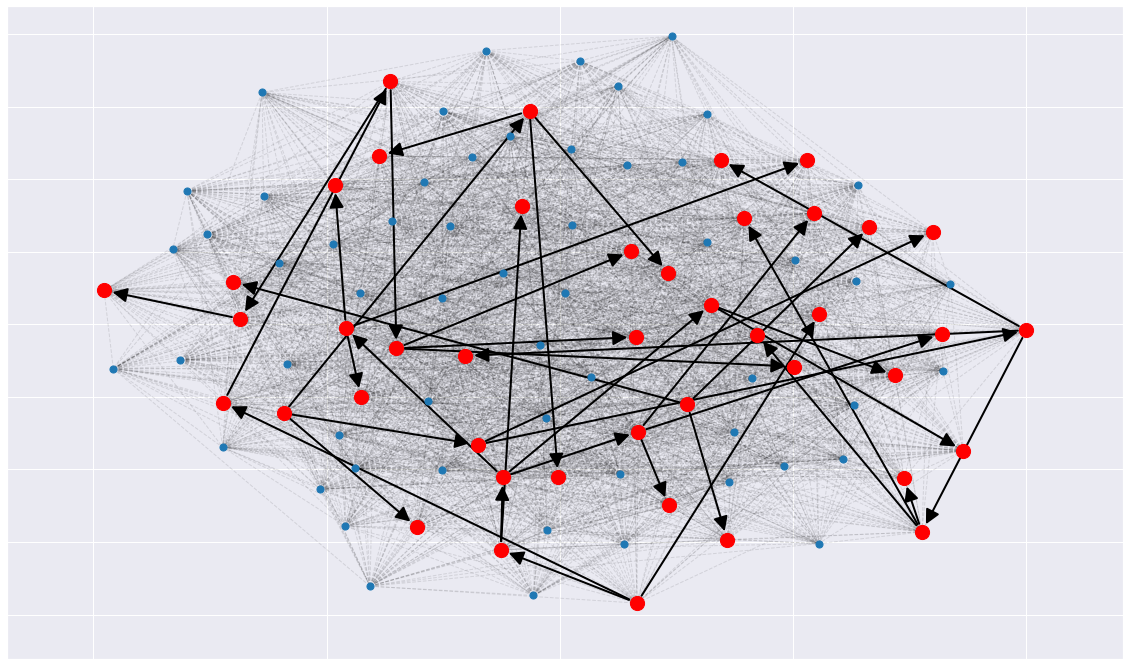

In [9]:
fig, ax = plt.subplots(figsize=(20,12))

pos = nx.spring_layout(graph)

nx.draw_networkx_nodes(graph, pos=pos, node_size = 50, ax = ax)#, node_color = colors, ax = ax)
nx.draw_networkx_edges(graph, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

nx.draw_networkx_nodes(rds_sample, pos=pos, node_size = 200, ax = ax, node_color = 'red')
nx.draw_networkx_edges(rds_sample, pos=pos, edge_color='black',alpha =1, width = 2, 
                       arrows = True, arrowsize = 30, ax = ax)
plt.show()

In [10]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                     n_seeds = 10, sample_size = 150, probs = [1/3,1/6,1/6,1/3])

rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))

A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()

In [11]:
tau = 1 
spec = 0.85
sens = 0.8
beta = np.array([0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1
rho = 0.5

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

omega = np.random.multivariate_normal(mean = np.zeros(n_samples), cov = tau*np.linalg.inv(D - rho*A))

x_rds = x[:n_samples]
theta = expit(logit(prevalence) + (x_rds@beta) + omega.reshape(-1,1))
p = sens*theta + (1 - spec)*(1 - theta)

T = ro.binomial(n = 1, p = p)

Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3
alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "adj_matrix"   : A,
    "precision"    : np.diag(A.sum(1)) - rho*A,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : 0, 
}

In [13]:
%%time
fit_rds_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_rds_imperfect)

CPU times: user 32.4 s, sys: 242 ms, total: 32.6 s
Wall time: 4min 35s


### Efficient implementation of CAR

In [16]:
#compiled = True
compiled = False

In [19]:
if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44f090bc9bbae0d8030c0101e011fc02 NOW.


In [86]:
tau = 1 
spec = 0.85
sens = 0.8
beta = np.array([0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1
rho = 0.5

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

omega = np.random.multivariate_normal(mean = np.zeros(n_samples), cov = tau*np.linalg.inv(D - rho*A))

x_rds = x[:n_samples]
theta = expit(logit(prevalence) + (x_rds@beta) + omega.reshape(-1,1))
p = sens*theta + (1 - spec)*(1 - theta)

T = ro.binomial(n = 1, p = p)

Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3
alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1
alpha_tau = 2
beta_tau = 2

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "adj_matrix"   : A,
    "adj_pairs"    :int(A.sum()/2),
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

In [87]:
%%time
fit_rds_imperfect_eff = sm.sampling(data=data, iter=8000)
summary = az.summary(fit_rds_imperfect_eff)

CPU times: user 15 s, sys: 369 ms, total: 15.4 s
Wall time: 53.5 s


In [88]:
stan_utility.check_all_diagnostics(fit_rds_imperfect_eff)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 16000 iterations ended with a divergence (0.0%)
0 of 16000 iterations saturated the maximum tree depth of 10 (0.0%)
Chain 0: E-BFMI = 0.06390668350549064
Chain 1: E-BFMI = 0.06165080056409222
Chain 2: E-BFMI = 0.0591156043927948
Chain 3: E-BFMI = 0.06864587367904972
  E-BFMI below 0.2 indicates you may need to reparameterize your model


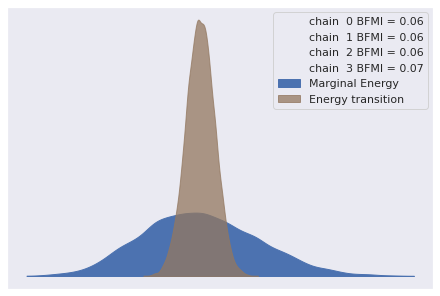

In [89]:
az.plot_energy(fit_rds_imperfect_eff)
plt.show()

In [90]:
info = fit_rds_imperfect_eff.to_dataframe()

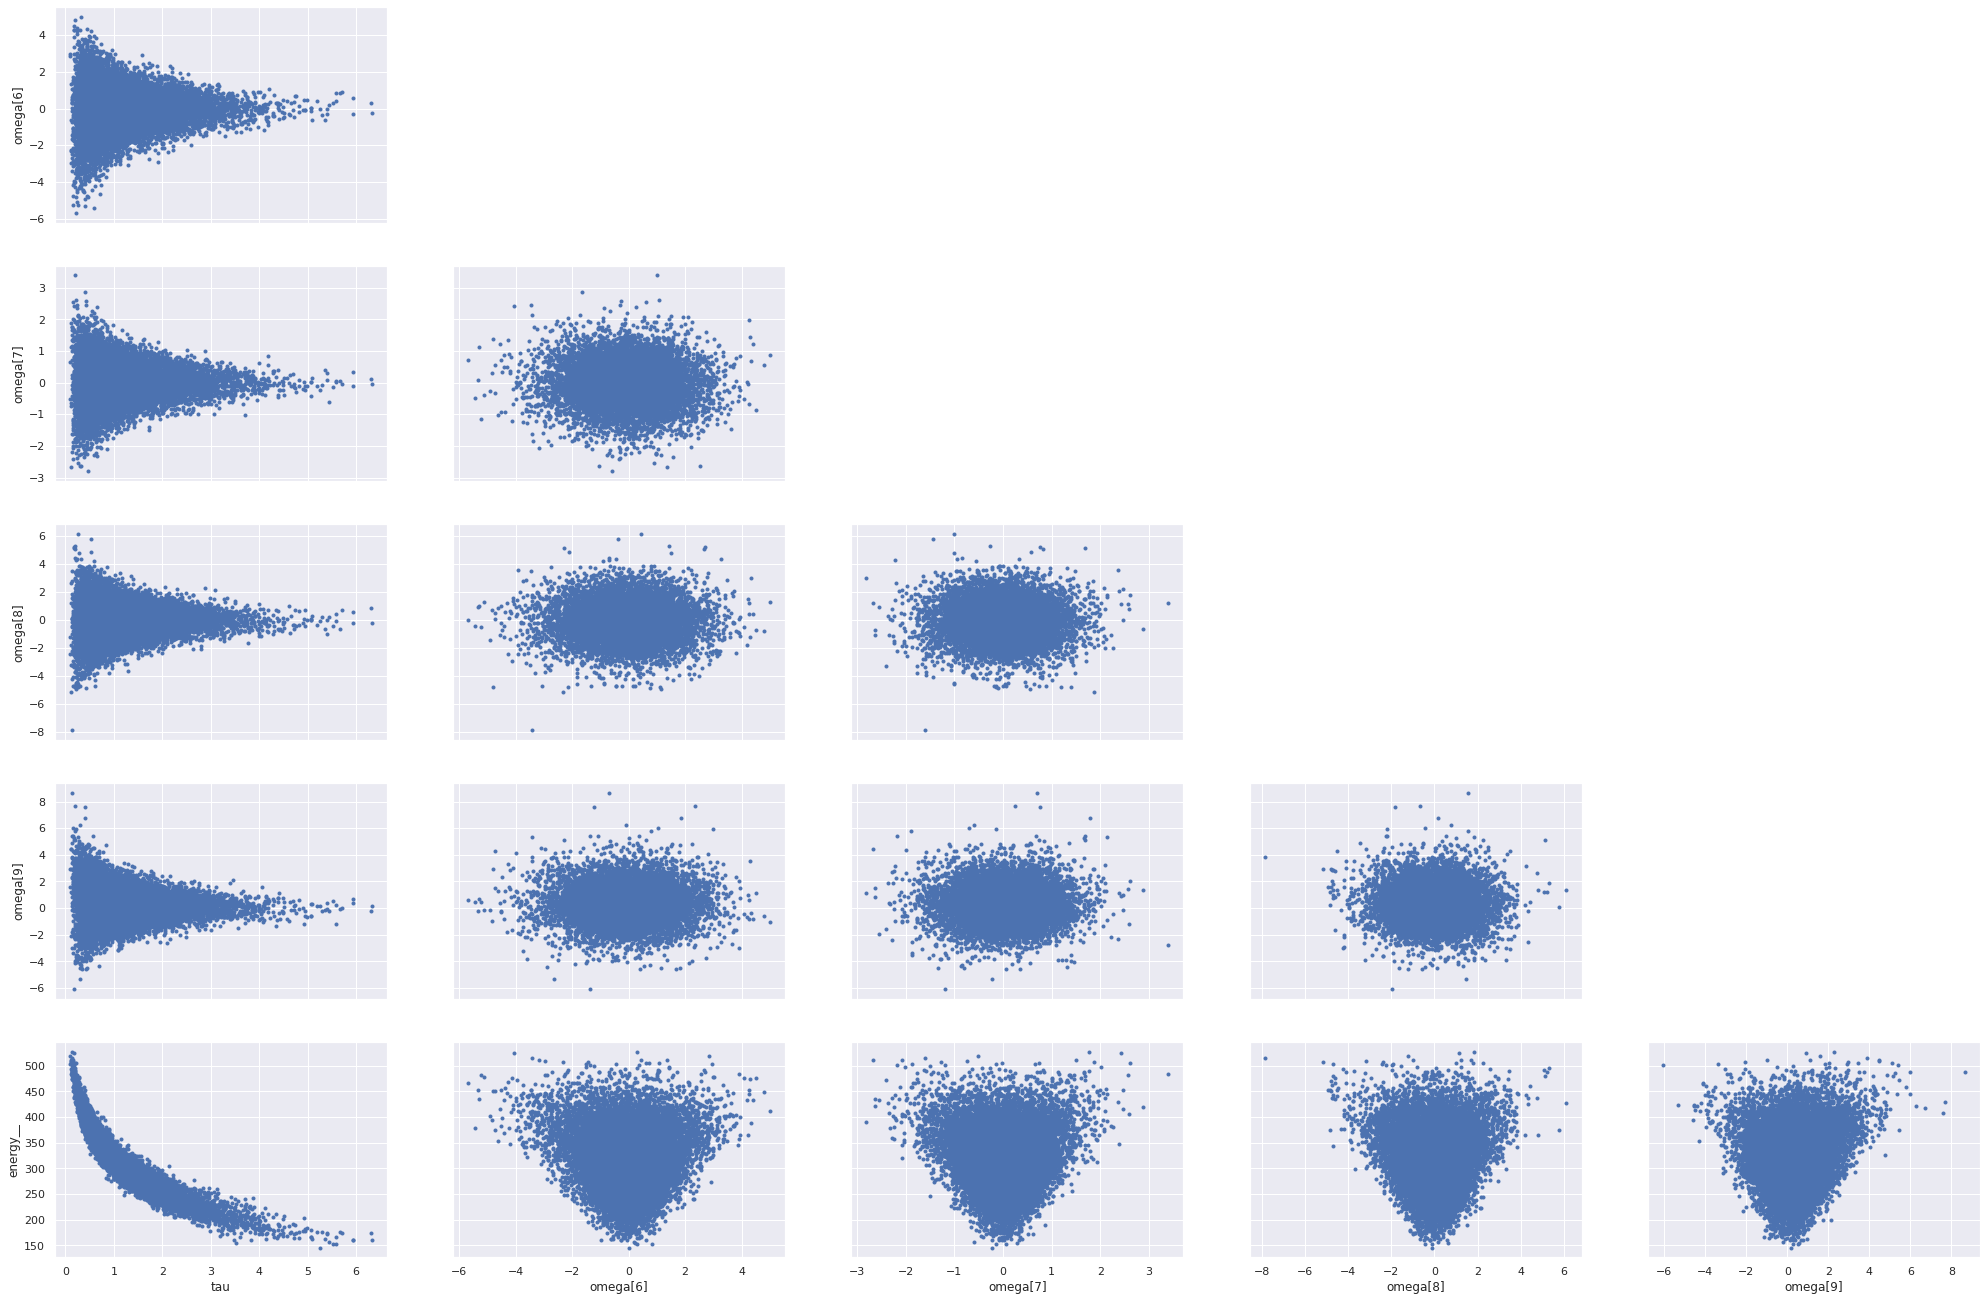

In [91]:
selected_vars = ['tau', 'omega[6]', 'omega[7]', 'omega[8]', 'omega[9]', 'energy__']
samples = {var: info[var] for var in selected_vars}

az.plot_pair(samples)

plt.show()

In [177]:
summary.loc[['prev', 'spec','sens', 'effects[0]','effects[1]','effects[2]','effects[3]','effects[4]', 'tau']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prev,0.157,0.069,0.042,0.281,0.001,0.001,4493.0,4493.0,4437.0,4948.0,1.00
spec,0.877,0.042,0.793,0.952,0.001,0.000,5695.0,5563.0,5443.0,4051.0,1.00
sens,0.865,0.097,0.695,1.000,0.002,0.001,4123.0,4028.0,3458.0,2683.0,1.00
effects[0],0.207,0.349,-0.445,0.871,0.005,0.004,4858.0,4033.0,4910.0,4860.0,1.00
effects[1],1.539,0.460,0.758,2.442,0.007,0.005,4234.0,3980.0,4373.0,4434.0,1.00
effects[2],-0.993,0.367,-1.752,-0.381,0.006,0.004,4447.0,4031.0,4752.0,4780.0,1.00
effects[3],1.116,0.390,0.417,1.864,0.006,0.005,3838.0,3588.0,3944.0,4272.0,1.00
effects[4],0.794,0.385,0.064,1.504,0.005,0.004,5642.0,5001.0,5728.0,5068.0,1.00
tau,1.018,0.741,0.030,2.328,0.066,0.047,125.0,125.0,90.0,90.0,1.04


In [ ]:
[0.1, 2.5, -1.0, 1.2, 0.3]